In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#from preprocess import train_test_seq#, scale_df
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

In [3]:
import xgboost as xgb

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

In [6]:
# SMAPE is typically defined such that its maximum value
# (for y_pred = 0) will be 200% 
# I have removed the factor 2 to reduce it to [0,100] range
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error

def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

In [7]:
def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [8]:
# Load in the time series
candy = pd.read_csv('candy_production.csv', 
            index_col='date',
            parse_dates=True)
candy.head()

IPG3113N
date                 
1972-01-01  85.598809
1972-02-01  71.741404
1972-03-01  65.948809
1972-04-01  64.490724
1972-05-01  64.933842

In [9]:
candy.shape

(564, 1)

## Train/Test split

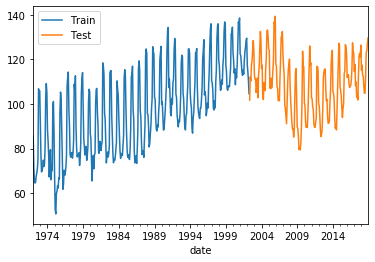

In [10]:
# Split the data into a train and test set
#df_train, df_test = candy.iloc[:-250], candy.iloc[-250:]
df_train, df_test = candy.iloc[:-200], candy.iloc[-200:]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test setsa dn show
df_train.plot(ax=ax)
df_test.plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

Univariate forecasting requires using the same sequence as features and target. Here is one choice where I do not use the test dataframe.

**Features**: 0-100 time points

**Target**  : 100-200 time points

In [11]:
X_train = df_train[-300:-200].to_numpy().reshape(-1,1)
X_test  = df_train[-200:-100].to_numpy().reshape(-1,1)

y_train = df_train[-200:-100].to_numpy().ravel()
y_test  = df_train[-100:].to_numpy().ravel() 

#X_train = df_train[-200:-100].to_numpy().reshape(-1,1)
#X_test  = df_test[-100:-50].to_numpy().reshape(-1,1)

#y_train = df_train[-200:-100].to_numpy().ravel()
#y_test  = df_test[-100:-50].to_numpy().ravel() 

## Baseline

### 1. Last value

In [12]:
y_base1 = np.copy(y_test)
y_base1[:] = y_test[0]

In [13]:
print_scores(y_test, y_base1)

R2 score: -0.44501992071288243
MSE score: 228.26728138975366
MAE score: 12.076231907505443
Median AE score: 9.37603926045103
MAPE score: 10.114830034905106
SMAPE score: 5.356733289578664


### 2. Rolling mean

In [14]:
candy_rolling_mean = candy.rolling(20).mean()

y_base2 = candy_rolling_mean.iloc[-100:].to_numpy()

In [15]:
print_scores(y_test, y_base2)

R2 score: -0.298747826933458
MSE score: 205.1609333653304
MAE score: 10.642681908653898
Median AE score: 7.633135193490908
MAPE score: 10.620370484183471
SMAPE score: 5.58266486675679


## Pipeline

In [16]:
pipe_lasso = Pipeline([
                       #('scale', MinMaxScaler(feature_range=(0, 1))),
                       ('scale', StandardScaler()),
                       ('lasso', Lasso())
                       ])

pipe_rf = Pipeline([
                    #('scale', MinMaxScaler(feature_range=(0, 1))),
                    ('scale', StandardScaler()),
                    ('rf', RandomForestRegressor(random_state=42))
                    ])

pipe_xgb = Pipeline([
                    #('scale', MinMaxScaler(feature_range=(0, 1))),
                    ('scale', StandardScaler()),
                    ('xgb', xgb.XGBRegressor())
                    ])

In [17]:
params_lasso = {'lasso__alpha': np.logspace(-4,1,10)}
              
params_rf = {
             #'rf__criterion': ['mae', 'mse'],
             'rf__max_depth': [2, 4, 8],
             #'rf__max_features': ['auto', 'sqrt', None],
             'rf__min_samples_leaf': [2, 4, 8],
             'rf__n_estimators': [8, 16, 32, 64]
            }

params_xgb = {
              'xgb__learning_rate': [0.001,0.01,0.1,0.25],
              'xgb__max_depth': [4,8,16],
              'xgb__subsample': [0.6,0.8],
              'xgb__colsample_bytree': [0.4,0.6,0.8],
              'xgb__n_estimators': [32,64,128],
              'xgb__seed': [1337]
             }

## GridSearchCV

### LASSO

In [18]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gs_lasso = GridSearchCV(pipe_lasso,
                        param_grid=params_lasso,
                        scoring='neg_mean_absolute_error',
                        cv=my_cv,
                        n_jobs=4) 

In [19]:
# Fit to the training set
gs_lasso.fit(X_train,y_train)

# Predict
y_pred_lasso = gs_lasso.predict(X_test)

# Compute and print the metrics
print(f"Tuned Lasso Alpha: {gs_lasso.best_params_}")
print(f"Tuned Lasso Score: {gs_lasso.score(X_test, y_test)}")

Tuned Lasso Alpha: {'lasso__alpha': 2.782559402207126}
Tuned Lasso Score: -17.29391429915223


In [20]:
print_scores(y_test, y_pred_lasso)

R2 score: -1.6596253138861394
MSE score: 420.13638096881834
MAE score: 17.29391429915223
Median AE score: 16.92541778766853
MAPE score: 14.43984346357555
SMAPE score: 7.970033459916509


### Random Forests

In [21]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=params_rf,
                     scoring='neg_mean_absolute_error',
                     cv=my_cv, 
                     n_jobs=4)

In [22]:
# Fit to the training set
gs_rf.fit(X_train,y_train)

# Predict
y_pred_rf = gs_rf.predict(X_test)

# Compute and print the metrics
print(f"Tuned RF params: {gs_rf.best_params_}")
print(f"Tuned RF Score:  {gs_rf.score(X_test, y_test)}")

Tuned RF params: {'rf__max_depth': 2, 'rf__min_samples_leaf': 8, 'rf__n_estimators': 16}
Tuned RF Score:  -19.740117799280988


In [23]:
print_scores(y_test, y_pred_rf)

R2 score: -2.4912056251799735
MSE score: 551.4996751320172
MAE score: 19.740117799280988
Median AE score: 17.706203309761726
MAPE score: 16.456281090024376
SMAPE score: 9.229567931690722


### XGBoost

In [24]:
my_cv = TimeSeriesSplit(n_splits=2).split(X_train)

#xgb.XGBRegressor()
gs_xgb = GridSearchCV(estimator=pipe_xgb,
                     param_grid=params_xgb,
                     scoring='neg_mean_absolute_error',
                     cv=my_cv, 
                     n_jobs=4)

In [25]:
# Fit to the training set
gs_xgb.fit(X_train,y_train)

# Predict
y_pred_xgb = gs_xgb.predict(X_test)

# Compute and print the metrics
print(f"Tuned XGB params: {gs_xgb.best_params_}")
print(f"Tuned XGB Score:  {gs_xgb.score(X_test, y_test)}")

/home/fnauman/anaconda3/envs/plotly/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[09:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Tuned XGB params: {'xgb__colsample_bytree': 0.4, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 4, 'xgb__n_estimators': 64, 'xgb__seed': 1337, 'xgb__subsample': 0.6}
Tuned XGB Score:  -20.49399834181531


In [26]:
print_scores(y_test, y_pred_xgb)

R2 score: -2.7632140988299243
MSE score: 594.4683802031687
MAE score: 20.49399834181531
Median AE score: 18.77203540674435
MAPE score: 17.096887003683783
SMAPE score: 9.6461764647038


## Plot `y_pred`

In [27]:
y_pred_lasso.shape, y_pred_rf.shape, y_pred_xgb.shape

((100,), (100,), (100,))

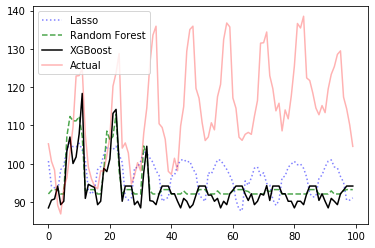

In [28]:
#t_test = np.linspace(4000, 4000+tst_sz, tst_sz)

plt.plot(y_pred_lasso, 'b:', label='Lasso', alpha=0.5)
plt.plot(y_pred_rf, 'g--', label='Random Forest', alpha=0.7)
plt.plot(y_pred_xgb, 'k', label='XGBoost')
plt.plot(y_test, 'r', label='Actual', alpha=0.3)
#plt.plot(y_base1, 'k-.', label='Base1', alpha=0.3)
#plt.plot(y_base2, 'k-.', label='Base2', alpha=0.4)
plt.legend()

**Conclusion** (MAPE scores): Lasso (14), RF (16), XGBoost (17) are struggling to do better than baseline scores of 10. The first 20 or so forecasting steps are doing relatively better but the longer evolution is hard to predict.

The reason could be small dataset. I also have not explored hyperparameter optimization extensively.